In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec


import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import folium 
import json
import math
from math import radians, cos, sin, asin, sqrt
import itertools
import statistics as stats
from statistics import mean

import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap

import bokeh

print('All imported!')

All imported!


In [2]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from ipywidgets import interact
from bokeh.models import ColumnDataSource, FactorRange, Select, CustomJS
from bokeh.plotting import output_file, save, figure, show


output_notebook()

Loading BokehJS ...

In [3]:
# Set global font
plt.rcParams['font.family'] = 'Georgia'  # Use 'sans-serif', 'monospace', 'cursive', etc.
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.weight'] = 'normal'  # Options: 'light', 'normal', 'bold'
print('Pretty :)')

Pretty :)


In [4]:
from folium import plugins

# Datasets and motivation

After moving to Copenhagen, the cycling infrastructure in Helsinki appears all of a sudden quite poor. We got intrigued to understand, how the state of the infrastructure influences both ***safety*** and ***feeling of safety***. To do so, we are analyzing the accident locations in relation to the bike route network. In addition, we can augment our quantitative findings with qualitative insights as the city conducts a survey on cycling each year. There is also citybike data available which offers the possibility to build understanding on which are the highly trafficed areas.

Data used is all public data from Helsinki. We are merging a few different datasets to serve our needs.

- 'baana_viivat.shp' – main bike routes as a shapefile
- 'PKS_Postinumeroalueet_2024.shp' – postal code areas of Helsinki, again as a shapefile.
- 'HKI_traffic_accidents' – the dataset includes all traffic accidents in Helsinki region from 2000 until 2023. The dataset has 53402 rows in total.

We joint the traffic accident data with the postal code areas to be able to analyze the spatial nature of the accidents via barcharts as well. The prelimenary processes also included transforming the Finnish data to EPSG 4326 which works with JSON-visuals.

In [18]:
# Load and reproject shapefile for main bike routes
baanat_shp = gpd.read_file("/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/baanat/baana_viivat.shp")
baanat_3879 = baanat_shp.set_crs(epsg=3879) 
baanat_4326 = baanat_3879.to_crs(epsg=4326)
baanat_geojson = baanat_4326.to_json()

# Optional: Save to GeoJSON for Folium or reuse
baanat_4326.to_file("baanat.geojson", driver="GeoJSON")


In [21]:
#read the accurate bikelines
main_bike_routes = gpd.read_file("/Users/maijavalimaki/Documents/GitHub/social-data-visualization-2025/helsinki data/main_bike_routes_2025_wgs84.geojson")
main_bike_routes.head()


fid       id                                  uuid  \
0    1  1696085  88aa6a79-70c6-46cc-a8d3-60e2c96e7d0a   
1    2  1696086  b4bf3fb1-3eb6-4de7-8f99-f3e979f4dac1   
2    3  1693613  7264377b-6ad6-42be-bd11-248bc8abbf2a   
3    4  1693628  71e318b1-16fa-4043-a691-4a5553430d38   
4    5  1623361  1907909f-e595-11ec-b99b-0050569c84ab   

                     paatyyppi                                 alatyyppi  \
0  Jalankulku ja pyöräliikenne                                  Suojatie   
1  Jalankulku ja pyöräliikenne  Jalkakäytävä ja pyörätie samassa tasossa   
2  Jalankulku ja pyöräliikenne                               Pyöräkaista   
3  Jalankulku ja pyöräliikenne                               Pyöräkaista   
4  Jalankulku ja pyöräliikenne                                  Pyörätie   

       silta_alikulku                    yksisuuntaisuus       hierarkia  \
0  Maanpinnan tasossa                    Kaksisuuntainen  Pääpyöräreitti   
1  Maanpinnan tasossa                    Kaksisuuntainen  Pääpyöräreitti   
2  Maanpinnan tasossa  Yksisuuntainen digitointisuuntaan  Pääpyöräreitti   
3  Maanpinnan tasossa  Yksisuuntainen digitointisuuntaan  Pääpyöräreitti   
4  Maanpinnan tasossa                    Kaksisuuntainen  Pääpyöräreitti   

   korkeuslahde  nimi  pituus lisatietoja yhtdatanomistaja  \
0             0  None    6.31        None    KAMI/Helsinki   
1             0  None   30.84        None    KAMI/Helsinki   
2             0  None   16.57        None    KAMI/Helsinki   
3             0  None    9.08        None    KAMI/Helsinki   
4             0  None   21.77        None    KAMI/Helsinki   

  paivitetty_tietopalveluun                                           geometry  
0                2025-04-22  LINESTRING (24.92953 60.19524, 24.92961 60.19527)  
1                2025-04-22  LINESTRING (24.92961 60.19527, 24.92964 60.195...  
2                2025-04-22  LINESTRING (24.91837 60.18807, 24.91834 60.187...  
3                2025-04-22   LINESTRING (24.91739 60.1867, 24.91735 60.18663)  
4                2025-04-22  LINESTRING (24.88479 60.19624, 24.88474 60.196...

In [6]:
postal_codes_gdf = gpd.read_file("/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/PKS_Postinumeroalueet_2024.shp")
postal_codes_gdf = postal_codes_gdf.to_crs(epsg=4326)
postal_codes_gdf = postal_codes_gdf.drop(columns = ['Postitoimi', 'PostitoiRU', 'NimiRU', 'Kunta_nro'])
postal_codes_gdf.columns = ['POSTAL CODE', 'NAME', 'CITY', 'geometry' ]

# Step 2: Save to GeoJSON (optional)
postal_codes_gdf.to_file("postal_codes.geojson", driver='GeoJSON')
postal_codes_gdf.head()

POSTAL CODE                           NAME      CITY  \
0       00100  Helsinki Keskusta - Etu-Töölö  Helsinki   
1       00120                      Punavuori  Helsinki   
2       00130                Kaartinkaupunki  Helsinki   
3       00140       Kaivopuisto - Ullanlinna  Helsinki   
4       00150              Eira - Hernesaari  Helsinki   

                                            geometry  
0  POLYGON ((24.91739 60.17664, 24.91766 60.17666...  
1  POLYGON ((24.94093 60.16721, 24.94107 60.16727...  
2  POLYGON ((24.94193 60.16764, 24.95107 60.1679,...  
3  POLYGON ((24.94835 60.16103, 24.94846 60.1603,...  
4  POLYGON ((24.94545 60.15314, 24.94237 60.12659...

In [7]:
df_accidents = pd.read_csv('HKI_traffic_accidents.csv', sep = ';')
df_accidents = df_accidents.dropna(subset=['ita_etrs', 'pohj_etrs'])

# Create geometry from ETRS coordinates
df_accidents['geometry'] = df_accidents.apply(
    lambda row: Point(float(row['ita_etrs']), float(row['pohj_etrs'])),
    axis=1
)

# Convert to GeoDataFrame and update coordinate system
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry='geometry', crs="EPSG:3879")
gdf_accidents_wgs84 = gdf_accidents.to_crs(epsg=4326)

#edit columns
gdf_accidents_wgs84 = gdf_accidents_wgs84.drop(columns = ['pohj_etrs', 'ita_etrs'])
gdf_accidents_wgs84.columns = ['TYPE', 'SEVERITY', 'YEAR', 'geometry']

#translating
translations = {
    'JK':'PEDESTRIAN', 
    'PP': 'BICYCLE',
    'MA':'MOTOR VEHICLE', 
    'MP': 'MOTOR CYCLE'
}
gdf_accidents_wgs84['TYPE'] = gdf_accidents_wgs84['TYPE'].replace(translations)
rows = len(gdf_accidents_wgs84)
years = gdf_accidents_wgs84['YEAR'].unique()
start = years.min()
end = years.max()

print('Traffic accident data has been saved as "df_accidents". Rows with incomplete location data has been removed.\nCoordinate system has been changed to wgs84. Accidents types have been translated.')
print(f'The data has {rows} rows.')
print(f'Years included are {start}–{end}.')

Traffic accident data has been saved as "df_accidents". Rows with incomplete location data has been removed.
Coordinate system has been changed to wgs84. Accidents types have been translated.
The data has 53042 rows.
Years included are 2000–2023.


In [8]:
gdf_accidents_with_postal = gpd.sjoin(
    gdf_accidents_wgs84,
    postal_codes_gdf[['geometry', 'POSTAL CODE', 'NAME', 'CITY']],
    how='left',
    predicate='within'
)

gdf_accidents_with_postal.head()

TYPE  SEVERITY  YEAR                   geometry  index_right  \
0  PEDESTRIAN         1  2022  POINT (25.02996 60.19489)           65   
1  PEDESTRIAN         2  2022   POINT (25.0503 60.18363)           68   
2  PEDESTRIAN         2  2022  POINT (25.12339 60.22849)           79   
3  PEDESTRIAN         2  2022    POINT (24.9785 60.1905)           42   
4  PEDESTRIAN         2  2022  POINT (24.91935 60.18713)           14   

  POSTAL CODE         NAME      CITY  
0       00810  Herttoniemi  Helsinki  
1       00840    Laajasalo  Helsinki  
2       00950  Vartioharju  Helsinki  
3       00580  Verkkosaari  Helsinki  
4       00250   Taka-Töölö  Helsinki

In [9]:
postal_areas = gdf_accidents_with_postal['NAME'].unique()
print(f'{postal_areas}\n, there are {len(postal_areas)} areas in total')

['Herttoniemi' 'Laajasalo' 'Vartioharju' 'Verkkosaari' 'Taka-Töölö'
 'Itäkeskus-Marjaniemi' 'Puotinharju' 'Kallio' 'Puotila' 'Malmi'
 'Pukinmäki-Savela' 'Itä-Pasila' 'Kruununhaka' 'Viikki' 'Kontula - Vesala'
 'Helsinki Keskusta - Etu-Töölö' 'Kamppi - Ruoholahti' 'Maununneva'
 'Länsi-Pasila' 'Toukola-Vanhakaupunki' 'Länsi-Pakila'
 'Etu-Vallila - Alppila' 'Kalasatama' 'Lauttasaari' 'Munkkiniemi'
 'Kaivopuisto - Ullanlinna' 'Kaartinkaupunki' 'Suurmetsä' 'Tapanila'
 'Roihupellon teollisuusalue' 'Vallila' 'Metsälä-Etelä-Oulunkylä'
 'Kannelmäki' 'Punavuori' 'Munkkivuori-Niemenmäki' 'Sörnäinen'
 'Pohjois-Meilahti' 'Etelä-Haaga' 'Konala' 'Käpylä' 'Östersundom'
 'Myllypuro' 'Jakomäki - Alppikylä' 'Mellunmäki' 'Pohjois-Haaga'
 'Maunula-Suursuo' 'Pitäjänmäen teollisuusalue' 'Oulunkylä-Patola'
 'Eira - Hernesaari' 'Pihlajamäki' 'Tapaninvainio' 'Kivihaka' 'Roihuvuori'
 'Reimarla' 'Itä-Pakila' 'Etelä-Vuosaari' 'Puistola' 'Veräjämäki'
 'Keski-Töölö' 'Kuusisaari-Lehtisaari' 'Koskela-Helsinki' 'Lassila

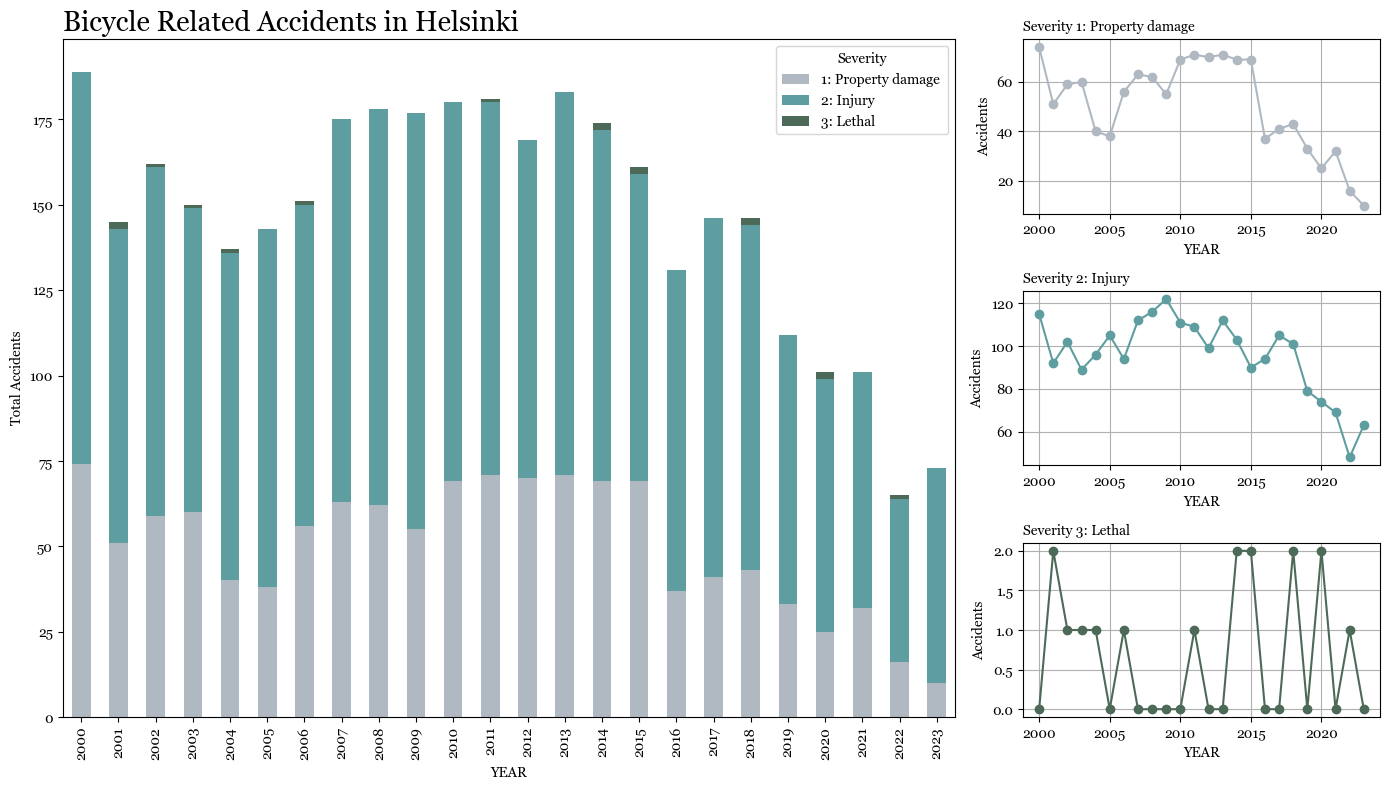

In [10]:
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('YEAR').reset_index().sort_values(by='YEAR').reset_index(drop=True)
accident_counts.columns = ['YEAR', 'COUNT']
#plot = accident_counts.plot(x = 'YEAR', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']
accidents_summary = gdf_accidents_bike.groupby(['YEAR', 'SEVERITY']).size().unstack(fill_value = 0)
legend_labels=['1: Property damage ', '2: Injury', '3: Lethal']


#creating a layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])  # All 3 rows, column 0
accidents_summary.plot(
    kind='bar',
    stacked=True,
    ylabel = 'Accidents',
    legend = True,
    color = colors,
    ax = ax_main
)
ax_main.set_title('Bicycle Related Accidents in Helsinki', fontsize=20, loc='left', fontweight = 'normal')
ax_main.legend(title='Severity', labels=['1: Property damage ', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')

# --- Smaller line plots for each severity level on the right ---
for i, severity in enumerate([1, 2, 3]):
    ax = fig.add_subplot(gs[i, 1])
    accidents_summary[severity].plot(
        kind='line',
        marker='o',
        color=colors[i],
        ax=ax
    )
    ax.set_title(f"Severity {severity}: {legend_labels[i].split(': ')[1]}", fontsize=10, loc='left')
    ax.set_ylabel('Accidents')
    ax.grid(True)



plt.tight_layout()
plt.show()


The main dataset we will be using has the structure seen below.
It includes the postal area information as well as has been filtered to bicycle related accidents only. It has 3530 rows.


TYPE  SEVERITY  YEAR                   geometry  index_right  \
0  BICYCLE         1  2022  POINT (24.98834 60.21955)           40   
1  BICYCLE         2  2022  POINT (24.92331 60.24753)           51   
2  BICYCLE         2  2022  POINT (24.88809 60.23918)           31   
3  BICYCLE         2  2022  POINT (24.96211 60.19872)           39   
4  BICYCLE         2  2022  POINT (25.05786 60.21513)           72   

  POSTAL CODE                        NAME      CITY  
0       00560       Toukola-Vanhakaupunki  Helsinki  
1       00670                   Paloheinä  Helsinki  
2       00420                  Kannelmäki  Helsinki  
3       00550                     Vallila  Helsinki  
4       00880  Roihupellon teollisuusalue  Helsinki

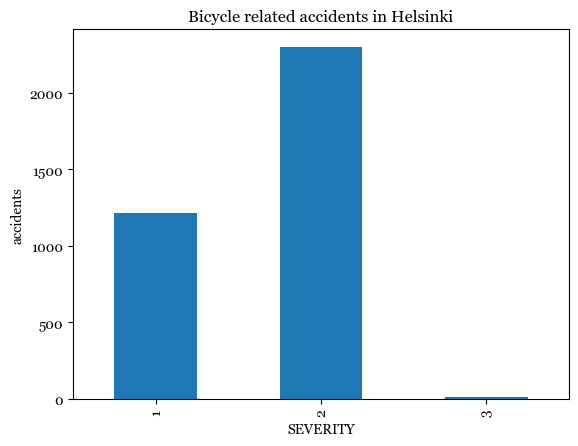

In [11]:
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('SEVERITY').reset_index().sort_values(by='SEVERITY').reset_index(drop=True)
accident_counts.columns = ['SEVERITY', 'COUNT']
plot = accident_counts.plot(x = 'SEVERITY', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

years = list(range(2000, 2024))
gdf_accidents_bike = gdf_accidents_bike[gdf_accidents_bike['YEAR'].isin(years)]
gdf_accidents_bike.head()
bike_accidents_amount = len(gdf_accidents_bike)
print(f'The main dataset we will be using has the structure seen below.\nIt includes the postal area information as well as has been filtered to bicycle related accidents only. It has {bike_accidents_amount} rows.')
gdf_accidents_bike.head()


In [12]:
lethal = [3]
injury = [2]
property_damage = [1]
severe = [3]

gdf_accidents_bike_severe = gdf_accidents_bike[gdf_accidents_bike['SEVERITY'].isin(severe)]
len(gdf_accidents_bike_severe)

16

Text(0.5, 1.0, 'Bicycle related accidents in Helsinki since 2000 by postal area')

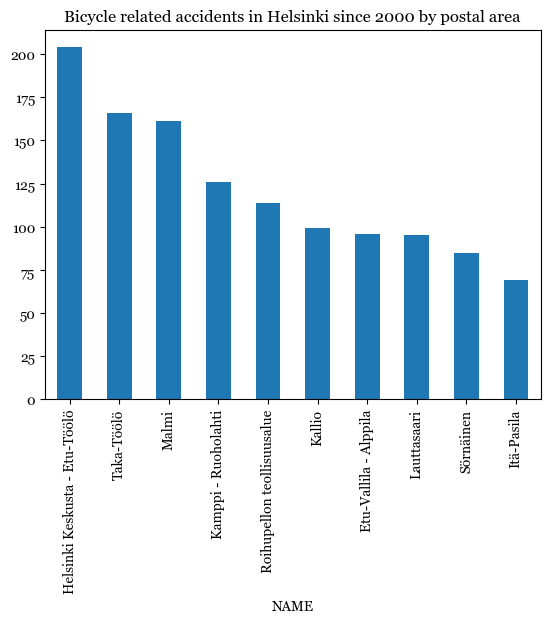

In [13]:
areal_counts = gdf_accidents_bike.value_counts('NAME').reset_index()
areal_counts_top10 = areal_counts[0:10]
top_10 = list(areal_counts_top10['NAME'])
top10_gdf = postal_codes_gdf[postal_codes_gdf['NAME'].isin(top_10)]
plot = areal_counts_top10.plot(x = 'NAME', y = 'count', kind = 'bar', legend = False)
plt.title('Bicycle related accidents in Helsinki since 2000 by postal area')

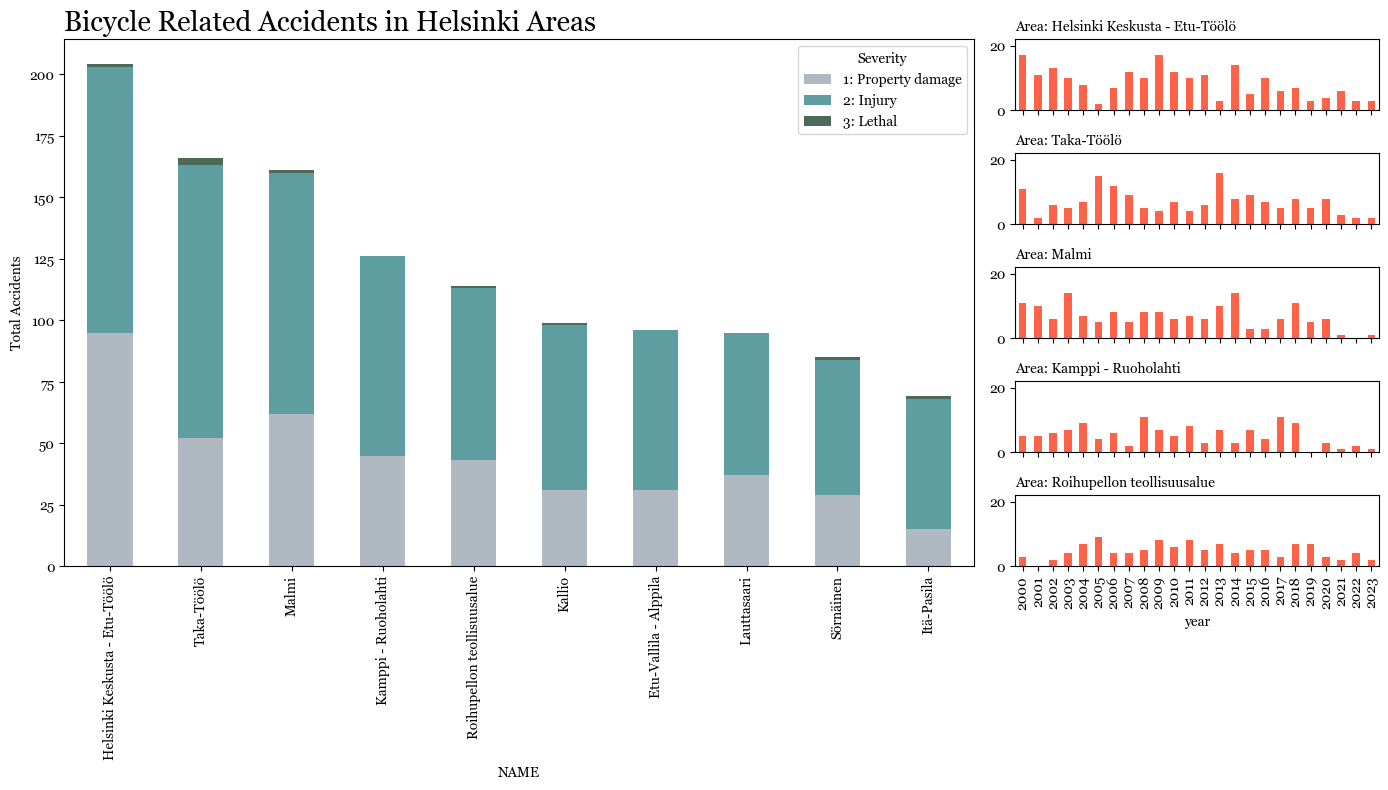

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define colors
colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']

# --- Accident summary by severity and area (for bar plot) ---
areal_accidents_summary = (
    gdf_accidents_bike
    .groupby(['SEVERITY', 'NAME'])
    .size()
    .unstack(fill_value=0)
)

# Sort areas by total accidents (descending)
sorted_areas = areal_accidents_summary.sum(axis=0).sort_values(ascending=False).index

# Get top 10 and top 5 area names
top_10 = sorted_areas[:10].tolist()
top_5 = sorted_areas[:5].tolist()

# Prepare data for plotting
summary_top10 = areal_accidents_summary[top_10].T  # rows = areas, columns = severity
summary_top5 = areal_accidents_summary[top_5].T

# --- Time series summary by year and area (for line plots) ---
area_year_summary = (
    gdf_accidents_bike
    .groupby(['YEAR', 'NAME'])
    .size()
    .unstack(fill_value=0)
)
shared_ymax = area_year_summary[top_5].max().max()

# --- Create layout ---
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(5, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])
summary_top10.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax_main
)
ax_main.set_title('Bicycle Related Accidents in Helsinki Areas', fontsize=20, loc='left', fontweight='normal')
ax_main.legend(title='Severity', labels=['1: Property damage', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')
ax_main.set_xlabel('NAME')
ax_main.set_xticklabels(summary_top10.index, rotation=90)

# --- Yearly trends for top 5 areas on the right ---
for i, area in enumerate(top_5):
    ax = fig.add_subplot(gs[i, 1])
    area_year_summary[area].plot(
        kind='bar',
        ax=ax,
        color = 'tomato'
    )
    ax.set_title(f"Area: {area}", fontsize=10, loc='left')
    #ax.set_ylabel('Accidents')
    ax.set_ylim(0, shared_ymax + 5)
    ax.grid(False)
    if i < 4:
        ax.set_xticklabels([])  # Hide x-axis labels except for bottom plot
        ax.set_xlabel('')
    else:
        ax.set_xlabel('year')

plt.tight_layout()
plt.show()


In [15]:
gdf_accidents_bike_severe.head()

TYPE  SEVERITY  YEAR                   geometry  index_right  \
29   BICYCLE         3  2022  POINT (25.11307 60.23219)           81   
166  BICYCLE         3  2020  POINT (24.89469 60.19297)           14   
167  BICYCLE         3  2020  POINT (25.03619 60.19323)           72   
379  BICYCLE         3  2018  POINT (24.96307 60.17902)           37   
380  BICYCLE         3  2018  POINT (24.87766 60.19173)           22   

    POSTAL CODE                        NAME      CITY  
29        00970                  Mellunmäki  Helsinki  
166       00250                  Taka-Töölö  Helsinki  
167       00880  Roihupellon teollisuusalue  Helsinki  
379       00530                      Kallio  Helsinki  
380       00330                 Munkkiniemi  Helsinki

In [23]:
#zooming to HKI
HKI_map = folium.Map([60.192059, 24.94584], zoom_start=12)
#SF City Hall:
folium.Marker([60.170278, 24.952222],
              popup='Helsingin tuomiokirkko',
              icon=folium.Icon(color='blue', icon='church',
                               prefix='fa')
             ).add_to(HKI_map)

style_function = lambda x: {
    'color': 'red',
    'weight': 3,
    'opacity': 0.8,
    'style': '-*-'
}

style_function_postal_codes = lambda x: {
    'color': 'black',
    'weight': 1,
    'opacity': 0.9,
    'fill': False
}


#severe accidents
gdf_accidents_bike_severe.loc[:,'lat'] = gdf_accidents_bike_severe.geometry.y
gdf_accidents_bike_severe.loc[:,'lon'] = gdf_accidents_bike_severe.geometry.x

#all accidents
gdf_accidents_bike['lat'] = gdf_accidents_bike.geometry.y
gdf_accidents_bike['lon'] = gdf_accidents_bike.geometry.x

#markers for lethal accidents 
for _, row in gdf_accidents_bike_severe.iterrows():
    folium.Marker(
        location = [row['lat'], row['lon']],
        icon=folium.Icon(color='black', icon='cross', prefix='fa'),
        fill=False,
        fill_opacity=0.7,
        popup=f"{row['TYPE']} – Severity: {row['SEVERITY']}, Year: {row['YEAR']}"
    ).add_to(HKI_map)

#heatmap
heat_data = [[row['lat'], row['lon']] for _, row in gdf_accidents_bike.iterrows()]

HeatMap(
    heat_data,
    min_opacity=0.8,
    radius = 5,
    blur=12,
    max_zoom=18
).add_to(HKI_map)

#main bike routes
'''folium.GeoJson(
    data=main_bike_routes_2025_wgs84,
    name="Baanat",
    style_function=style_function
).add_to(HKI_map)'''
folium.GeoJson(main_bike_routes.geometry).add_to(HKI_map)

#postal code areas
'''folium.GeoJson(
    data = postal_codes_gdf,
    name = 'Postal codes',
    style_function=style_function_postal_codes
    
).add_to(HKI_map)'''

HKI_map

In [17]:
import json
json.loads(json.dumps(main_bike_routes))  # test if it's still valid JSON

TypeError: Object of type GeoDataFrame is not JSON serializable